In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

#from nltk.corpus import stopwords
# preprocess words
import nltk
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils, to_categorical
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.externals import joblib
from gensim.models.keyedvectors import KeyedVectors

import time

from keras.layers import Input, Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional, MaxPooling1D, Conv1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
import h5py


# model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix




from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.utils import compute_class_weight


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [1]:
import tensforflow as tf
tf.test.gpu_device_name()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/table_for_nlp_analysis.csv')

In [4]:
# df = pd.read_csv("table_for_nlp_analysis.csv")

In [5]:
# rename columns

col_list_new = ['overall', 'reviewtext', 'asin']
col_list_old = ['for_nlp_analysis.overall', 'for_nlp_analysis.reviewtext', 'for_nlp_analysis.asin']
col_replacement = dict(zip(col_list_old, col_list_new))

df.rename(columns = col_replacement, inplace = True)

In [6]:
df = df.dropna(subset=['reviewtext'])

Text(0, 0.5, 'Count')

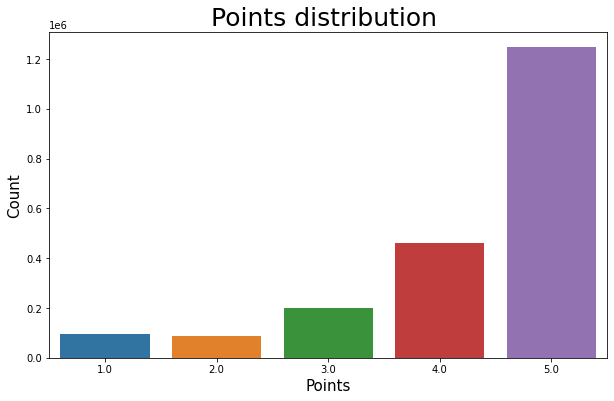

In [7]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution ", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [8]:
# merge two dicts x and y into z: z = {**x, **y}

In [9]:
# df['overall'] = df['overall'].map(lambda x: x-1)

In [10]:
lab_vals = [1, 2, 3, 4, 5]
new_lab_vals = [0, 0, 1, 2, 2]

di_map = dict(zip(lab_vals, new_lab_vals))

di_map = dict(zip(lab_vals, new_lab_vals))
df['overall'] = df['overall'].map(di_map)

Text(0, 0.5, 'Count')

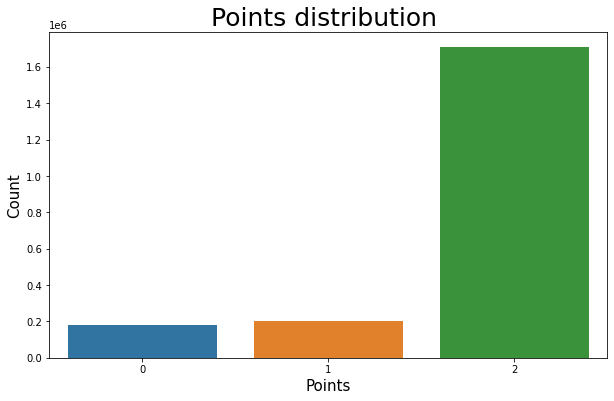

In [11]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution ", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [12]:
df['reviewtext'] = df['reviewtext'].str.lower()

In [13]:
# Reviews (feature Description in the dataset) - correlation of the length of the review with the rating

In [14]:
desc_length = df['reviewtext'].apply(len)

print(f"The longest description contains: {desc_length.max()} characters")
print(f"The shortest description contains: {desc_length.min()} characters")
print(f"Median number of characters is: {desc_length.median()}")
print(f"Standard deviation of reviews: {np.std(desc_length)}")

The longest description contains: 8141 characters
The shortest description contains: 1 characters
Median number of characters is: 135.0
Standard deviation of reviews: 195.6603269086265


In [15]:
df = df.assign(desc_length = df['reviewtext'].apply(len))

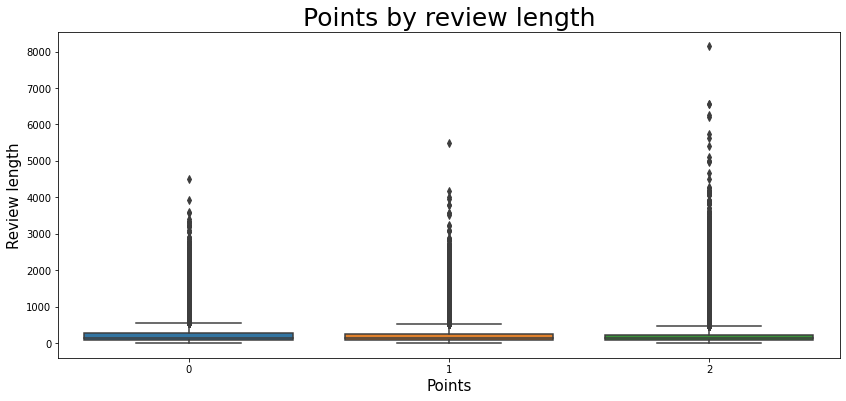

In [16]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
plt.show()

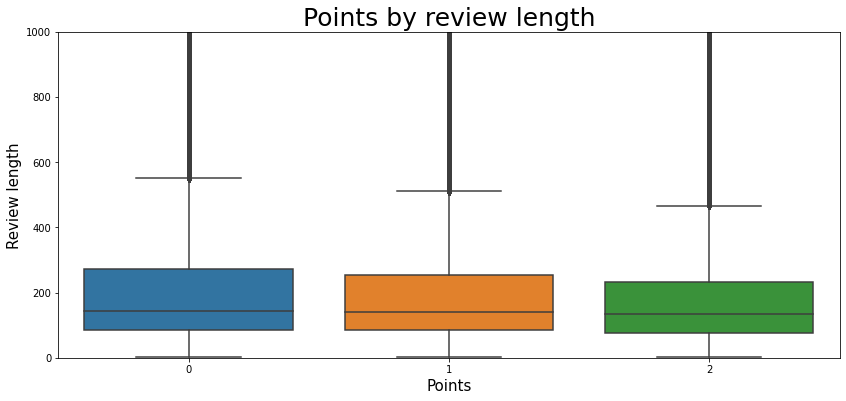

In [17]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
points_length.set_ylim([0,1000])
plt.show()

In [18]:
# interestingly there is no correlation of the length of the review and the rating assigned

In [19]:
# this dataset is rather large - take a random sample of the wordcloud, hence going forward, I will take
# a sample of the dataset

In [20]:
df2 = df.sample(n = 5000, random_state=42)

In [21]:
# WordCloud of reviews shows most common words in reviews excluding stopwords.

In [22]:
stopwords = set(STOPWORDS)
newStopWords = ["book", "read", "story", "character", "read", "series", "time", "reading", "author"]
stopwords.update(newStopWords)

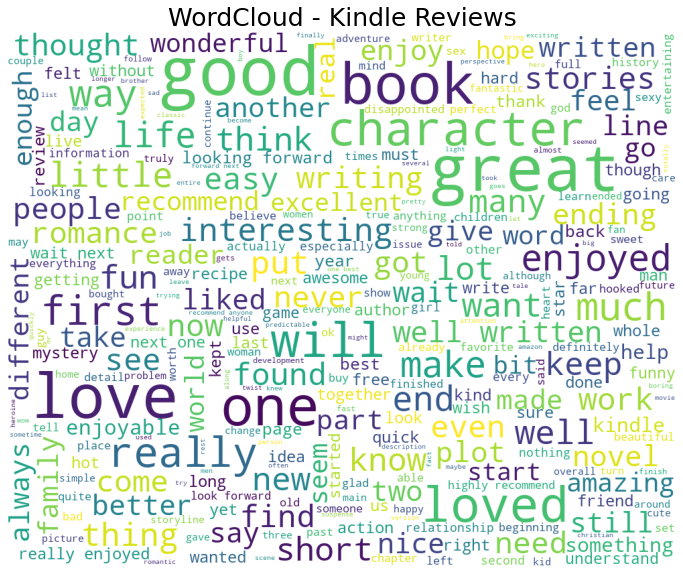

In [23]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=100, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df2['reviewtext']))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WordCloud - Kindle Reviews",fontsize=25)
plt.axis('off')
plt.show()

# Train Test Split

In [24]:
# lowest class needs to be 0 for the to_categorical replacement
#df2['overall'] = df2.overall.apply(lambda x: x-1)

In [25]:
# Some Preprocessing

In [26]:
df2.head()

,overall,reviewtext,asin,desc_length
906069,2,great read for younger readers - still enterta...,B00EFWU9QY,103
153301,2,i am saying this because all of lee child's bo...,B00ZRDPPU0,129
1491557,0,"first, this book is riddled with distracting t...",B00CAE71L0,777
688726,2,this story is by far my absolute favorite from...,B006KD2TP0,230
1521821,1,great,B016X4TTP8,5


In [27]:
# 3.step: removing the stopwords
stopwords_1 = STOPWORDS

In [28]:
no_list = ['no', 'nor', 'not']

In [29]:
keep_stops = [e for e in stopwords_1 if e.endswith("n't")] + [e for e in stopwords_1 if e.endswith("n'")]\
                + [e for e in stopwords_1 if e.endswith("n") and len(e)>=4] + no_list

In [30]:
keep_stops

["don't",
 "wouldn't",
 "shouldn't",
 "shan't",
 "weren't",
 "wasn't",
 "doesn't",
 "mustn't",
 "hasn't",
 "can't",
 "isn't",
 "haven't",
 "didn't",
 "aren't",
 "won't",
 "hadn't",
 "couldn't",
 'then',
 'between',
 'again',
 'been',
 'than',
 'down',
 'when',
 'no',
 'nor',
 'not']

In [31]:
#stopwords = set(list(set(stopwords_1) - set(keep_stops)))
stopwords = set(stopwords_1) 

In [32]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [33]:
def remove_stopwords (df, colname, stopwords = stopwords):
    df[colname] = list(map(lambda x: x.lower().split(), df[colname]))
    df[colname] = list(map(lambda line: list(filter(lambda word: word not in stopwords, line)), df[colname]))
    df[colname] = list(map(lambda x: " ".join(x), df[colname]))
    
    return df

In [34]:
df2 = remove_stopwords(df = df2, colname = 'reviewtext')

In [35]:
df2.head()

,overall,reviewtext,asin,desc_length
906069,2,great read younger readers - still entertainin...,B00EFWU9QY,103
153301,2,saying lee child's books adults. much need was...,B00ZRDPPU0,129
1491557,0,"first, book riddled distracting typos grammati...",B00CAE71L0,777
688726,2,story far absolute favorite kristen ashley (oo...,B006KD2TP0,230
1521821,1,great,B016X4TTP8,5


In [36]:
X = df2["reviewtext"]
y = df2["overall"]
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=random_state, stratify = y, shuffle = True)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
#                                                           random_state=random_state)

# Text preprocessing



First, in order to conduct topic analysis I have to preprocess reviews of wines:




In [37]:
# tokenizing and filtering out basic punctuation and setting to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [38]:
# dictionary mapping words (str) to their index (int)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
print(word_index)

Found 10981 unique tokens.
{'book': 1, 'read': 2, 'story': 3, 'good': 4, 'great': 5, 'love': 6, 'one': 7, 'books': 8, 'series': 9, 'reading': 10, 'characters': 11, 'loved': 12, 'it': 13, 'really': 14, 'will': 15, 'well': 16, 'enjoyed': 17, 'time': 18, 'author': 19, 'first': 20, 'next': 21, 'much': 22, 'wait': 23, 'written': 24, 'recommend': 25, 'little': 26, 'put': 27, 'life': 28, 'way': 29, 'end': 30, 'short': 31, 'want': 32, 'see': 33, 'fun': 34, 'many': 35, 'interesting': 36, 'even': 37, 'looking': 38, 'know': 39, 'stories': 40, 'new': 41, 'easy': 42, 'two': 43, 'think': 44, 'forward': 45, 'writing': 46, 'lot': 47, 'found': 48, 'character': 49, 'best': 50, 'another': 51, 'never': 52, 'find': 53, 'romance': 54, 'better': 55, 'plot': 56, 'enjoy': 57, 'people': 58, 'got': 59, 'make': 60, 'ending': 61, 'now': 62, 'liked': 63, 'keep': 64, 'down': 65, 'me': 66, 'always': 67, 'go': 68, 'still': 69, 'nice': 70, 'made': 71, 'thought': 72, 'real': 73, 'family': 74, 'hard': 75, 'every': 76, 'k

In [39]:
# turning texts into sequences (list of word indexes)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
#sequences_val = tokenizer.texts_to_sequences(X_val)

In [40]:
sequences_train

[[106, 2, 25, 112, 5216, 937],
 [189, 2744, 938, 365, 1007, 1584, 38, 45, 21, 423],
 [162, 2205, 5217, 214, 711, 1008, 238, 75, 18, 123, 667, 190],
 [189,
  3,
  5218,
  171,
  203,
  2206,
  270,
  3572,
  668,
  577,
  510,
  1829,
  37,
  93,
  1585,
  1586,
  123,
  259,
  182,
  1093,
  3,
  74,
  805,
  17,
  47],
 [196, 327, 17, 67, 146, 3, 68, 253],
 [6,
  260,
  8,
  244,
  7,
  712,
  3573,
  230,
  2207,
  231,
  53,
  116,
  462,
  3574,
  201,
  52,
  68,
  2207,
  115,
  5219,
  5220,
  3575,
  5221,
  3576,
  34,
  4,
  46],
 [4, 133, 2, 2208, 220, 939, 352, 1830, 3577, 5222, 1831, 261, 1178, 445, 6],
 [35, 117, 3578, 1832, 511, 636, 2],
 [1,
  1833,
  66,
  6,
  5223,
  5224,
  259,
  99,
  100,
  99,
  5225,
  463,
  60,
  79,
  553,
  95,
  103,
  2],
 [20, 2209, 5226, 1, 5, 2, 38, 2, 1587],
 [5, 3579, 262, 4, 806],
 [4,
  1,
  148,
  144,
  113,
  376,
  759,
  2745,
  105,
  1094,
  446,
  25,
  424,
  245,
  447,
  1009,
  3580],
 [408, 2],
 [293],
 [106, 2, 940],


In [41]:
# checking the length of the longest review
max_len = max([len(x) for x in sequences_train+sequences_test])
print(f"The longest description has {max_len} words.")

The longest description has 255 words.


In [42]:
# padding sequences so that they are of equal length
X_train_nn = sequence.pad_sequences(sequences_train, maxlen = max_len)
X_test_nn = sequence.pad_sequences(sequences_test, maxlen = max_len)
#X_val_nn = sequence.pad_sequences(sequences_val, maxlen = max_len)

In [43]:
X_train_nn

array([[    0,     0,     0, ...,   112,  5216,   937],
       [    0,     0,     0, ...,    45,    21,   423],
       [    0,     0,     0, ...,   123,   667,   190],
       ...,
       [    0,     0,     0, ..., 10981,  1041,   576],
       [    0,     0,     0, ...,     0,   515,  1046],
       [    0,     0,     0, ...,   268,  1360,   968]], dtype=int32)

In [44]:
## turning y into one-hots
nb_classes = len(y_train.unique()) # equal to a number of labels
y_train_nn = np_utils.to_categorical(y_train, nb_classes)
y_test_nn = np_utils.to_categorical(y_test, nb_classes)
#y_val_nn = np_utils.to_categorical(y_val, nb_classes)

In [45]:
#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [46]:
#!unzip glove.42B.300d.zip.1

In [47]:
 def load_glove_model(glove_input_file, word2vec_output_file="gensim_glove_vectors.txt"):
     glove2word2vec(glove_input_file, word2vec_output_file)
     return KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [48]:
start_time = time.time()
print(start_time)

# glove_model = load_glove_model("/content/gdrive/MyDrive/Colab Notebooks/glove.42B.300d.txt")

glove_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/gensim_glove_vectors.txt", binary=False)

# glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

1619166513.7139778
--- 10.473548762003581 minutes ---


In [49]:
len(word_index)+1

10982

In [50]:
# code to download, unzip, preprocess and load pre-trained Glove model with embeddings
# I saved an array of filetered embeddings and load it below 


start_time = time.time()
print(start_time)
input_dim = len(word_index)+1 # This is the size of the vocabulary in the text data.
output_dim = 300 # This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
#output_dim = int(3/5*max_len)
# creating embedding matrix containing only embeddings for words used in wines reviews

emb_matrix = np.zeros((input_dim, output_dim))
for w, i in word_index.items():
  try:
    vect = glove_model[w]
    if vect is not None:
      emb_matrix[i] = vect
  except:
    pass


joblib.dump(emb_matrix, "emb_matrix.joblib")
print("--- %s seconds ---" % (time.time() - start_time))

1619167142.1691241
--- 0.09574341773986816 seconds ---


In [51]:
# checking how many words from wines reviews are reprezented in pre-trained Glove Embeddings
print(len(([key for key in word_index.keys() if key in glove_model]))/len(word_index))

0.9378016574082506


In [52]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38600999, -0.030722  ,  0.010253  , ...,  0.69549   ,
         0.10035   , -0.31393999],
       [ 0.0015074 ,  0.28264999, -0.21710999, ...,  0.72561002,
        -0.18332   , -0.28645   ],
       ...,
       [-0.17896   ,  0.16960999,  0.22600999, ..., -0.079703  ,
         0.25832   , -0.26076999],
       [-0.29833999, -0.20559999,  0.27785   , ...,  0.041444  ,
         0.35916001, -0.20025   ],
       [ 0.05664   , -0.34303999,  0.32275999, ...,  0.36368001,
        -0.27871001, -0.1061    ]])

In [53]:
emb_matrix.shape

(10982, 300)

### Training the model

In [54]:
# model = Model(inputs = input, outputs = x)
# model.shape

In [55]:
class_weights_numpy = compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [56]:
keys_cl_weights = np.unique(y_train).tolist()

In [57]:
values_cl_weights = class_weights_numpy.tolist()

In [58]:
class_weights = dict(zip(keys_cl_weights, values_cl_weights))

In [59]:
class_weights

{0: 3.767730496453901, 1: 3.365003958828187, 2: 0.4102712617047978}

In [60]:
emb_matrix.shape

(10982, 300)

In [61]:
def build_model(list_of_layers):

    input_1 = Input(shape = (max_len,))

    x = Embedding(input_dim = emb_matrix.shape[0], 
                  output_dim = emb_matrix.shape[1], 
                  input_length = max_len, #This is the length of input sequences
                  weights = [emb_matrix], 
                  trainable = False)(input_1)

    
    for layer in list_of_layers:
        x = layer(x)
        
    model = Model(inputs = input_1, outputs = x)  
    model.summary()

    model.compile(loss = "categorical_crossentropy", 
                  optimizer = "adam", 
                  metrics = ["categorical_accuracy"])
    
    
    #model = load_model(str(filename)+".h5py")

    return model

In [62]:
def evaluate_model(model, X_train, X_val, y_train, y_val, filename, batch_size=128):

    ext = ".h5py"# ".ckpt" # ".h5py"

    early_stopping = EarlyStopping(patience=3, monitor="val_loss")
    take_best_model = ModelCheckpoint(str(filename)+ext, monitor = "val_loss", verbose = 1, save_best_only=True)

    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2,
              batch_size=batch_size, 
              callbacks=[early_stopping, take_best_model], class_weight = class_weights)
    
    model = load_model(str(filename)+ext)
    
    # predict probabilities for test set
    y_prob = model.predict(X_val, verbose=0)
    
    # predict crisp classes for test set
    y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)

    # accuracy: (tp + tn) / (p + n)
    acc = accuracy_score(y_val, y_pred)  
    # precision tp / (tp + fp) # a lot of false positives - lowers precision of the model
    precision = precision_score(y_val, y_pred, average='weighted')
    #print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_val, y_pred, average='weighted')
    #print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val, y_pred, average='weighted')
    #print('F1 score: %f' % f1)
    
    return acc, precision, recall, f1

In [65]:
models = {  
          "clf_LSTM_500n":      
                                [LSTM(500),
                                 Dropout(0.5),
                                 Dense(nb_classes, activation="softmax")],
           
          "clf_BiLSTM_500n":      
                                [Bidirectional(LSTM(500)),
                                 Dropout(0.5),
                                 Dense(nb_classes, activation="softmax")],    
            
          "clf_LSTM_500n_MultipleDense":      
                                [LSTM(500),
                                 Dropout(0.5),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Dense(nb_classes, activation="softmax")],
    
          "clf_BiLSTM_500n_MultipleDense":      
                                [Bidirectional(LSTM(500)),
                                 Dropout(0.5),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Dense(nb_classes, activation="softmax")],
          
          "clf_CNN1D_500n_BiLSTM_MultipleDense":      
                                [Conv1D(32, kernel_size=2, padding='valid', input_shape=(1000, 1)),
                                 MaxPooling1D(pool_size=2),
                                 Bidirectional(LSTM(500)),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Dense(nb_classes, activation="softmax")],
          
          "clf_BiLSTM_500n_CNN1D_MultipleDense":      
                                [Bidirectional(LSTM(500, return_sequences=True)),
                                 Conv1D(32, kernel_size=3, padding='valid'),
                                 MaxPooling1D(pool_size=2),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Flatten(),
                                 Dense(nb_classes, activation="softmax")]
}



In [66]:
results_df = pd.DataFrame()

for model_name, layer_params in models.items():
    out = pd.DataFrame([list(evaluate_model(build_model(layer_params), X_train_nn, X_test_nn, y_train_nn, y_test, filename = model_name))], columns = ['accuracy', 'precision', 'recall', 'f1-score'])
    results_df = results_df.append(out)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 255, 300)          3294600   
_________________________________________________________________
lstm_6 (LSTM)                (None, 500)               1602000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 1503      
Total params: 4,898,103
Trainable params: 1,603,503
Non-trainable params: 3,294,600
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 223s 8s/step - loss: 1.1121 - categorical_accuracy: 0.

INFO:tensorflow:Assets written to: clf_LSTM_500n.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n.h5py/assets


Epoch 2/100
27/27 [==============================] - 222s 8s/step - loss: 0.8712 - categorical_accuracy: 0.6909 - val_loss: 0.9327 - val_categorical_accuracy: 0.6188

Epoch 00002: val_loss did not improve from 0.73148
Epoch 3/100
27/27 [==============================] - 222s 8s/step - loss: 0.7797 - categorical_accuracy: 0.6755 - val_loss: 0.6526 - val_categorical_accuracy: 0.7412

Epoch 00003: val_loss improved from 0.73148 to 0.65260, saving model to clf_LSTM_500n.h5py


INFO:tensorflow:Assets written to: clf_LSTM_500n.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n.h5py/assets


Epoch 4/100
27/27 [==============================] - 224s 8s/step - loss: 0.7089 - categorical_accuracy: 0.7141 - val_loss: 0.8175 - val_categorical_accuracy: 0.6576

Epoch 00004: val_loss did not improve from 0.65260
Epoch 5/100
27/27 [==============================] - 222s 8s/step - loss: 0.6267 - categorical_accuracy: 0.7471 - val_loss: 0.8810 - val_categorical_accuracy: 0.6024

Epoch 00005: val_loss did not improve from 0.65260
Epoch 6/100
27/27 [==============================] - 220s 8s/step - loss: 0.5936 - categorical_accuracy: 0.7295 - val_loss: 0.7892 - val_categorical_accuracy: 0.6588

Epoch 00006: val_loss did not improve from 0.65260
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 255, 300)          3294600   

INFO:tensorflow:Assets written to: clf_BiLSTM_500n.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n.h5py/assets


Epoch 2/100
27/27 [==============================] - 425s 16s/step - loss: 0.9181 - categorical_accuracy: 0.6332 - val_loss: 0.6919 - val_categorical_accuracy: 0.7353

Epoch 00002: val_loss improved from 1.01191 to 0.69189, saving model to clf_BiLSTM_500n.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n.h5py/assets


Epoch 3/100
27/27 [==============================] - 421s 16s/step - loss: 0.8263 - categorical_accuracy: 0.6943 - val_loss: 0.7123 - val_categorical_accuracy: 0.7024

Epoch 00003: val_loss did not improve from 0.69189
Epoch 4/100
27/27 [==============================] - 421s 16s/step - loss: 0.6992 - categorical_accuracy: 0.7294 - val_loss: 0.7244 - val_categorical_accuracy: 0.7012

Epoch 00004: val_loss did not improve from 0.69189
Epoch 5/100
27/27 [==============================] - 420s 16s/step - loss: 0.6524 - categorical_accuracy: 0.7509 - val_loss: 0.9494 - val_categorical_accuracy: 0.6094

Epoch 00005: val_loss did not improve from 0.69189
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 255, 300)          3294600

INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


Epoch 2/100
27/27 [==============================] - 213s 8s/step - loss: 1.0098 - categorical_accuracy: 0.5562 - val_loss: 0.9824 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.08571 to 0.98238, saving model to clf_LSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


Epoch 3/100
27/27 [==============================] - 214s 8s/step - loss: 0.8867 - categorical_accuracy: 0.6935 - val_loss: 0.7732 - val_categorical_accuracy: 0.6753

Epoch 00003: val_loss improved from 0.98238 to 0.77320, saving model to clf_LSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


Epoch 4/100
27/27 [==============================] - 215s 8s/step - loss: 0.8235 - categorical_accuracy: 0.6744 - val_loss: 0.8537 - val_categorical_accuracy: 0.6188

Epoch 00004: val_loss did not improve from 0.77320
Epoch 5/100
27/27 [==============================] - 215s 8s/step - loss: 0.7873 - categorical_accuracy: 0.6813 - val_loss: 0.8274 - val_categorical_accuracy: 0.6671

Epoch 00005: val_loss did not improve from 0.77320
Epoch 6/100
27/27 [==============================] - 214s 8s/step - loss: 0.6801 - categorical_accuracy: 0.7134 - val_loss: 0.6553 - val_categorical_accuracy: 0.7224

Epoch 00006: val_loss improved from 0.77320 to 0.65533, saving model to clf_LSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_LSTM_500n_MultipleDense.h5py/assets


Epoch 7/100
27/27 [==============================] - 213s 8s/step - loss: 0.7058 - categorical_accuracy: 0.7138 - val_loss: 0.6671 - val_categorical_accuracy: 0.7412

Epoch 00007: val_loss did not improve from 0.65533
Epoch 8/100
27/27 [==============================] - 212s 8s/step - loss: 0.6254 - categorical_accuracy: 0.7714 - val_loss: 0.7199 - val_categorical_accuracy: 0.6929

Epoch 00008: val_loss did not improve from 0.65533
Epoch 9/100
27/27 [==============================] - 215s 8s/step - loss: 0.5600 - categorical_accuracy: 0.7773 - val_loss: 0.7513 - val_categorical_accuracy: 0.6753

Epoch 00009: val_loss did not improve from 0.65533
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 255, 300)          3294600   

INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


Epoch 2/100
27/27 [==============================] - 422s 16s/step - loss: 1.1075 - categorical_accuracy: 0.4529 - val_loss: 1.4017 - val_categorical_accuracy: 0.3682

Epoch 00002: val_loss did not improve from 1.08523
Epoch 3/100
27/27 [==============================] - 423s 16s/step - loss: 1.0284 - categorical_accuracy: 0.5224 - val_loss: 0.8626 - val_categorical_accuracy: 0.6212

Epoch 00003: val_loss improved from 1.08523 to 0.86262, saving model to clf_BiLSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


Epoch 4/100
27/27 [==============================] - 426s 16s/step - loss: 0.8883 - categorical_accuracy: 0.6564 - val_loss: 0.7815 - val_categorical_accuracy: 0.6929

Epoch 00004: val_loss improved from 0.86262 to 0.78153, saving model to clf_BiLSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


Epoch 5/100
27/27 [==============================] - 428s 16s/step - loss: 0.7974 - categorical_accuracy: 0.6914 - val_loss: 0.6295 - val_categorical_accuracy: 0.7729

Epoch 00005: val_loss improved from 0.78153 to 0.62950, saving model to clf_BiLSTM_500n_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_MultipleDense.h5py/assets


Epoch 6/100
27/27 [==============================] - 426s 16s/step - loss: 0.8047 - categorical_accuracy: 0.7239 - val_loss: 0.8139 - val_categorical_accuracy: 0.6412

Epoch 00006: val_loss did not improve from 0.62950
Epoch 7/100
27/27 [==============================] - 425s 16s/step - loss: 0.7234 - categorical_accuracy: 0.6839 - val_loss: 0.6660 - val_categorical_accuracy: 0.7341

Epoch 00007: val_loss did not improve from 0.62950
Epoch 8/100
27/27 [==============================] - 425s 16s/step - loss: 0.6726 - categorical_accuracy: 0.7113 - val_loss: 0.7081 - val_categorical_accuracy: 0.6741

Epoch 00008: val_loss did not improve from 0.62950
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 255, 300)          3294600

INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


Epoch 2/100
27/27 [==============================] - 168s 6s/step - loss: 0.9806 - categorical_accuracy: 0.6031 - val_loss: 0.8523 - val_categorical_accuracy: 0.6718

Epoch 00002: val_loss improved from 1.03024 to 0.85234, saving model to clf_CNN1D_500n_BiLSTM_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


Epoch 3/100
27/27 [==============================] - 166s 6s/step - loss: 0.8767 - categorical_accuracy: 0.7187 - val_loss: 0.6859 - val_categorical_accuracy: 0.7259

Epoch 00003: val_loss improved from 0.85234 to 0.68590, saving model to clf_CNN1D_500n_BiLSTM_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


Epoch 4/100
27/27 [==============================] - 165s 6s/step - loss: 0.7712 - categorical_accuracy: 0.7201 - val_loss: 0.6101 - val_categorical_accuracy: 0.7765

Epoch 00004: val_loss improved from 0.68590 to 0.61008, saving model to clf_CNN1D_500n_BiLSTM_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_CNN1D_500n_BiLSTM_MultipleDense.h5py/assets


Epoch 5/100
27/27 [==============================] - 166s 6s/step - loss: 0.7997 - categorical_accuracy: 0.6703 - val_loss: 0.7227 - val_categorical_accuracy: 0.6847

Epoch 00005: val_loss did not improve from 0.61008
Epoch 6/100
27/27 [==============================] - 165s 6s/step - loss: 0.6610 - categorical_accuracy: 0.7275 - val_loss: 0.8414 - val_categorical_accuracy: 0.6247

Epoch 00006: val_loss did not improve from 0.61008
Epoch 7/100
27/27 [==============================] - 165s 6s/step - loss: 0.6016 - categorical_accuracy: 0.7027 - val_loss: 0.7036 - val_categorical_accuracy: 0.7024

Epoch 00007: val_loss did not improve from 0.61008
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 255)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 255, 300)          3294600   

INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 2/100
27/27 [==============================] - 444s 16s/step - loss: 0.9734 - categorical_accuracy: 0.6669 - val_loss: 0.8115 - val_categorical_accuracy: 0.6682

Epoch 00002: val_loss did not improve from 0.74265
Epoch 3/100
27/27 [==============================] - 446s 17s/step - loss: 0.8358 - categorical_accuracy: 0.6915 - val_loss: 0.9156 - val_categorical_accuracy: 0.6424

Epoch 00003: val_loss did not improve from 0.74265
Epoch 4/100
27/27 [==============================] - 447s 17s/step - loss: 0.7613 - categorical_accuracy: 0.7101 - val_loss: 0.7720 - val_categorical_accuracy: 0.6588

Epoch 00004: val_loss did not improve from 0.74265


In [67]:
results = results_df.copy()
results['model'] = list(models.keys())
results = results.sort_values(by="f1-score", ascending=False).reset_index(drop=True)

In [68]:
results

,accuracy,precision,recall,f1-score,model
0,0.805333,0.776924,0.805333,0.782558,clf_BiLSTM_500n_CNN1D_MultipleDense
1,0.772000,0.802483,0.772000,0.779085,clf_CNN1D_500n_BiLSTM_MultipleDense
2,0.758667,0.770607,0.758667,0.761451,clf_BiLSTM_500n_MultipleDense
3,0.744000,0.789070,0.744000,0.759532,clf_LSTM_500n
4,0.710667,0.811766,0.710667,0.749627,clf_LSTM_500n_MultipleDense
5,0.713333,0.793764,0.713333,0.746284,clf_BiLSTM_500n


### Load previously trained models and evaluate results

In [ ]:
def evaluate_loaded_model(filename, X_val, y_val):

    ext = ".h5py" # ".ckpt" # .h5py
    
    model = load_model(str(filename)+ext)
    
    # predict probabilities for test set
    y_prob = model.predict(X_val, verbose=0)
    
    # predict crisp classes for test set
    y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)
    
    # accuracy: (tp + tn) / (p + n)
    acc = accuracy_score(y_val, y_pred)
    
    # precision tp / (tp + fp)
    precision = precision_score(y_val, y_pred, average='weighted')
    
    # print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_val, y_pred, average='weighted')
    
    # print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val, y_pred, average='weighted')
    #print('F1 score: %f' % f1)
    
    return acc, precision, recall, f1

In [ ]:
results_df_loaded = pd.DataFrame()

for model in models.keys():
    print(model)
    out = pd.DataFrame([list(evaluate_loaded_model(filename = model, X_val = X_test_nn, y_val = y_test))], columns = ['accuracy', 'precision', 'recall', 'f1-score'])
    results_df_loaded = results_df_loaded.append(out)

In [ ]:
results_loaded = results_df_loaded.copy()
results_loaded['model'] = list(models.keys())
results_loaded = results_loaded.sort_values(by="f1-score", ascending=False).reset_index(drop=True)
results_loaded

In [ ]:
# Score on test set
# let's check how the best model scores on the test set

In [ ]:
# Training the 'winner' network architechture only on the full dataset

In [ ]:
model_winner = load_model("clf_LSTM_500n.h5py") #.ckpt #.h5py

In [ ]:
model_winner.evaluate(X_test_nn, y_test_nn)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
cm/cm.sum(axis = 1, keepdims = True)